# Retrieving and Plotting A SST/SSS Time Series From OOI

This guide assumes that you have a working Python install with the JupyterLab IDE and all packages installed from [this guide](). I learned much of the data analysis code that I will show here under the advising of Tom Connolly, who maintains many repositories with further resources on oceanographic and atmospheric data analysis that [you can find here](https://github.com/tompc35). 

#### Contents:
- [Introduction](#Introduction)
- [Accessing OOI Data](#Accessing-OOI-Data)
- [Analyzing OOI Data](#Analyzing-OOI-Data)

## Introduction

This notebook is intended to cover the basics of working with [Ocean Observatories Initative (OOI) Endurance Array](https://oceanobservatories.org/array/coastal-endurance/) oceanographic data [retrieved from their THREDDS server](https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/catalog.html). OOI "is a science-driven ocean observing network that delivers real-time data from more than 800 instruments to address critical science questions regarding the world’s oceans." They manage oceanic instrumentation throughout the world, but the array we are interested in, the Endurance Array, is an installation on the continental shelf of the Northeast Pacific Ocean. 

The moorings within the Endurance Array are made up of two sets of similar moorings on the Oregon and Washington coasts with three sites across the shelf - the shelf slope (500m-600m), the shelf (80m-90m), and the inner-shelf (25m-30m). This guide will focus on the latter. Each mooring consists of sea surface moorings (SSM) with sensors such as conductivity, temperature, and depth (CTD) meters and anemometers for wind velocity ([click here for a full list of OOI sensors](https://ooi-website.whoi.edu/instruments/)). In addition, OOI includes surface piercing profilers (SPP) which move throughout the water column on regular intervals and record the same oceanographic data that is taken at the surface mooring. 

The SSM data is what we will be analyzing today. We will be analyzing sea surface temperature and salinity (SST/SSS) time series from the inner-shelf site, although the techniques can be similarly applied to both the shelf and the shelf slope.

## Accessing OOI Data

OOI includes a [data explorer](https://dataexplorer.oceanobservatories.org/#ooi/array/CE?search=) that can be very helpful for getting a feel for the data. However, we want to do some analysis that will require downloading the data into Python, so we will instead access it through OOI's API. First, import xarray, which we will use to both load and work with the dataset.

In [1]:
import xarray as xr

The next step is to construct a URL that brings us to the data catalog for the instrument we want. Every instrument in the Endurance Array uses the same "base" URL. "Reference designators" appended to the base URL will bring us to the data from the instrument we want. I won't go into detail here, but a full explanation of reference designators for OOI [can be found here](https://oceanobservatories.org/knowledgebase/how-to-decipher-a-reference-designator/).

For now, I will just provide the necessary reference designator for the sea surface mooring conductivity, temperature, and depth unit (or SSM CTD - remember those acronyms?) which will provide the temperature and salinity data used in this analysis. 

In [2]:
base_url = 'https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/'

site = 'CE01ISSM'
node = 'RID16'
port = '03'
instrument = 'CTDBPC000'
method = 'recovered_host'
stream = 'ctdbp_cdef_dcl_instrument_recovered'
#combine into a complete reference designator
ref_des = ('-').join([site, node, port, instrument, method, stream])

#append to URL, including /catalog.html on the end
url = base_url + ref_des + '/catalog.html'
url

'https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/CE01ISSM-RID16-03-CTDBPC000-recovered_host-ctdbp_cdef_dcl_instrument_recovered/catalog.html'

Clicking the link output by the previous code will brings us to the catalog of data from the specified instrument. Next, we need to pick a deployment (i.e., a timeframe), which is somewhat arbitrary here but in general is guided by science questions and data availability.

I happen to know that 2019 has a good SST/SSS dataset, so I will scroll down to find the ```.nc``` file that covers the 2019 deployment (found simply by reading the dates in the catalog URLs). We only want to look for ```.nc``` files here since that file type is exactly what xarray is designed to handle. Click on the URL associated with deployment 11 (~April-October 2019), access through OPENDAP, and copy the data URL shown. We now are ready to load this into an xarray!

In [3]:
ctd_ds = xr.load_dataset('http://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/ooigoldcopy/public/CE01ISSM-RID16-03-CTDBPC000-recovered_host-ctdbp_cdef_dcl_instrument_recovered/deployment0011_CE01ISSM-RID16-03-CTDBPC000-recovered_host-ctdbp_cdef_dcl_instrument_recovered_20190420T033109.483000-20191022T233015.690000.nc')
ctd_ds

<xarray.Dataset>
Dimensions:                                            (obs: 2224)
Coordinates:
  * obs                                                (obs) int32 0 1 ... 2223
Data variables: (12/35)
    sea_water_pressure_qc_results                      (obs) float32 13.0 ......
    sea_water_pressure                                 (obs) float32 7.328 .....
    dcl_controller_timestamp                           (obs) object b'empty' ...
    sea_water_electrical_conductivity_qartod_results   (obs) float32 1.0 ... 1.0
    sea_water_pressure_qc_executed                     (obs) float32 29.0 ......
    sea_water_practical_salinity_qc_executed           (obs) float32 29.0 ......
    ...                                                 ...
    depth                                              (obs) float64 7.269 .....
    sea_water_pressure_qartod_results                  (obs) float32 1.0 ... 1.0
    sea_water_electrical_conductivity_qartod_executed  (obs) |S64 b'1' ... b'1'
    time                                               (obs) datetime64[ns] 2...
    sea_water_electrical_conductivity                  (obs) float32 3.516 .....
    sea_water_practical_salinity_qartod_executed       (obs) |S64 b'11' ... b...
Attributes: (12/73)
    node:                               RID16
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             ctdbp_cdef_dcl_instrument_recovered
    ...                                 ...
    geospatial_vertical_positive:       down
    lat:                                44.65683
    lon:                                -124.09533
    DODS.strlen:                        14
    DODS.dimName:                       string14
    DODS_EXTRA.Unlimited_Dimension:     obs

Finally, it's time to do some stuff with this data!

## Analyzing OOI Data

Take a moment to understand the organization of the xarray from the last section before proceding. Notice that it is organized, quite naturally, around "dimensions", "coordinates", and "data variables". This structure simplifies the understanding of complex, multidimensional data and is the true power of the NetCDF format. 

Dimensions (bolded coordinates) define the *shape* of the dataset. Every other coordinate and data variable must have the same length as its associated dimensions (notice the 's' - we can have more than one dimension per variable). The dimensions of another variable are shown in the parentheses after the variable name. Other coordinates define spatial and temporal locations of data variables but do not define the shape of the dataset itself. Data variables consist of everything else the dataset contains. Make sure you check the units of your downloaded data, which can also be easily viewed in a NetCDF file.

OOI SSM data from the Endurance Array ships with all data variables and coordinates a function of the dimension ```obs```, short for observation. This provides a simple counting of each time the sensor is sampling. However, it is not very useful from a data analysis perspective. Instead, we would the primary dimension be time, so our first task is to switch the dimension of the array. 

In [4]:
ctd_ds = ctd_ds.swap_dims({'obs':'time'})
ctd_ds

<xarray.Dataset>
Dimensions:                                            (time: 2224)
Coordinates:
    obs                                                (time) int32 0 1 ... 2223
  * time                                               (time) datetime64[ns] ...
Data variables: (12/34)
    sea_water_pressure_qc_results                      (time) float32 13.0 .....
    sea_water_pressure                                 (time) float32 7.328 ....
    dcl_controller_timestamp                           (time) object b'empty'...
    sea_water_electrical_conductivity_qartod_results   (time) float32 1.0 ......
    sea_water_pressure_qc_executed                     (time) float32 29.0 .....
    sea_water_practical_salinity_qc_executed           (time) float32 29.0 .....
    ...                                                 ...
    sea_water_density                                  (time) float64 1.023e+...
    depth                                              (time) float64 7.269 ....
    sea_water_pressure_qartod_results                  (time) float32 1.0 ......
    sea_water_electrical_conductivity_qartod_executed  (time) |S64 b'1' ... b'1'
    sea_water_electrical_conductivity                  (time) float32 3.516 ....
    sea_water_practical_salinity_qartod_executed       (time) |S64 b'11' ... ...
Attributes: (12/73)
    node:                               RID16
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             ctdbp_cdef_dcl_instrument_recovered
    ...                                 ...
    geospatial_vertical_positive:       down
    lat:                                44.65683
    lon:                                -124.09533
    DODS.strlen:                        14
    DODS.dimName:                       string14
    DODS_EXTRA.Unlimited_Dimension:     obs

Note that now the coordinate ```time``` is in bold, as we have made it the dimension of our dataset. We should also rename the pressure, temperature, and conductivity data variables from their current form (e.g., 'sea_water_temperature') to something a little easier to work with, since we'll be referencing them a lot. 

In [5]:
ctd_ds = ctd_ds.rename({'sea_water_temperature':'temp',
                        'sea_water_electrical_conductivity':'cond',
                        'sea_water_pressure':'pres'})

That should be a little easier on the hands now! One final step before plotting. You may have noticed that I told you we will be plotting the sea surface *salinity* but so far only have data for sea surface *conductivity*. Conductivity is what the CTD measures, but to get to salinity we would need to do quite a bit of physics, chemistry, and maths. Fortunately, others have done this before us, so we only need to use their results. For this, we use the TEOS-10 Gibbs Sea Water package and calculate the practical salinity from the conductivity, temperature, and pressure and assign it to a new variable in our xarray.

In [6]:
import gsw.conversions as conv

In [7]:
ctd_ds['sal_p'] = conv.SP_from_C(ctd_ds['cond']*10,ctd_ds['temp'],ctd_ds['pres'])

Note the factor ten in the formula being multiplied by the conductivity. This is because the function expected units (mS/cm) different from that which is in the dataset (S/m). Check your units and, when you get weird, unexpected results, check them again!

Now, we can finally make our plots, first importing the necessary module from the matplotlib package. 

In [8]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Temperature [$^oC$]')

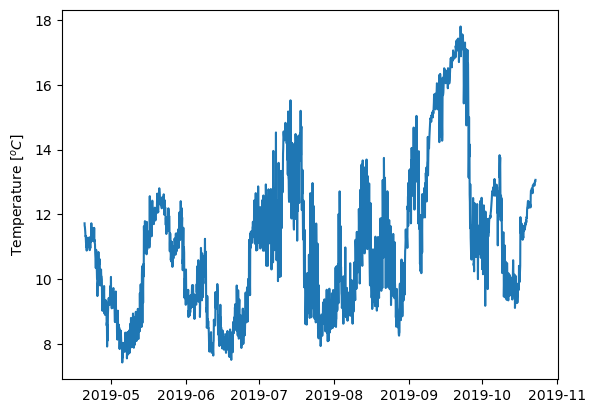

In [9]:
plt.plot(ctd_ds['time'],ctd_ds['temp'])
#the dollar signs around the oC allow Latex-style formatting in matplotlibe labels
plt.ylabel('Temperature [$^oC$]')

Text(0, 0.5, 'Practical Salinity [$PSU$]')

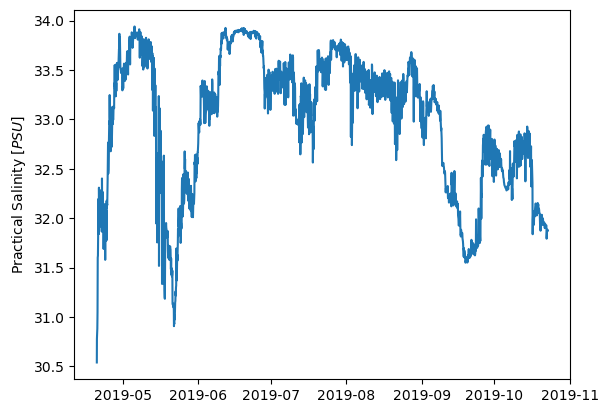

In [10]:
plt.plot(ctd_ds['time'],ctd_ds['sal_p'])
#the dollar signs around the oC allow Latex-style formatting in matplotlibe labels
plt.ylabel('Practical Salinity [$PSU$]')

There is so much more we could do with styling and customizing these plots that is outside the scope of this guide. If you want to add or change something in these plots, consider a Google search along the lines of 'how to ... matplotlib' and I am sure someone else has solved this problem before.

In [11]:
 ctd_ds = xr.load_dataset('http://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/ooigoldcopy/public/CE01ISSM-RID16-03-CTDBPC000-recovered_host-ctdbp_cdef_dcl_instrument_recovered/deployment0011_CE01ISSM-RID16-03-CTDBPC000-recovered_host-ctdbp_cdef_dcl_instrument_recovered_20190420T033109.483000-20191022T233015.690000.nc')
